<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>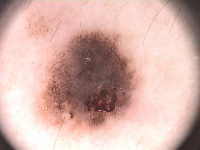</td><td>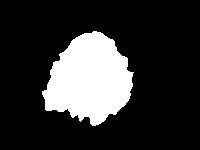</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!pip install opendatasets
import opendatasets as od

451d6c8d4143e6f1c8c4bd8dc2e9c123

In [2]:
od.download("https://www.kaggle.com/datasets/kanametov/ph2dataset")

Skipping, found downloaded files in "./ph2dataset" (use force=True to force download)


In [3]:
!ls ./ph2dataset/PH2Dataset
!ls ./ph2dataset/PH2Dataset/PH2_Dataset

PH2_Dataset  PH2_dataset.txt  PH2_dataset.xlsx	Readme.txt
IMD002	IMD023	IMD044	IMD088	IMD135	IMD157	IMD197	IMD254	IMD356	IMD382	IMD402	IMD424
IMD003	IMD024	IMD045	IMD090	IMD137	IMD159	IMD198	IMD256	IMD360	IMD383	IMD403	IMD425
IMD004	IMD025	IMD047	IMD091	IMD138	IMD160	IMD199	IMD278	IMD364	IMD384	IMD404	IMD426
IMD006	IMD027	IMD048	IMD092	IMD139	IMD161	IMD200	IMD279	IMD365	IMD385	IMD405	IMD427
IMD008	IMD030	IMD049	IMD101	IMD140	IMD162	IMD203	IMD280	IMD367	IMD386	IMD406	IMD429
IMD009	IMD031	IMD050	IMD103	IMD142	IMD164	IMD204	IMD284	IMD368	IMD388	IMD407	IMD430
IMD010	IMD032	IMD057	IMD105	IMD143	IMD166	IMD206	IMD285	IMD369	IMD389	IMD408	IMD431
IMD013	IMD033	IMD058	IMD107	IMD144	IMD168	IMD207	IMD304	IMD370	IMD390	IMD409	IMD432
IMD014	IMD035	IMD061	IMD108	IMD146	IMD169	IMD208	IMD305	IMD371	IMD392	IMD410	IMD433
IMD015	IMD036	IMD063	IMD112	IMD147	IMD170	IMD210	IMD306	IMD372	IMD393	IMD411	IMD434
IMD016	IMD037	IMD064	IMD118	IMD149	IMD171	IMD211	IMD312	IMD374	IMD394	IMD413	IMD435
IMD017	IMD038	IMD0

In [4]:
root_dir = '/content/ph2dataset/PH2Dataset/PH2_Dataset'

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [5]:
images = []
lesions = []
from skimage.io import imread
import os

for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.bmp'):
            file_path = os.path.join(root, file)
            if '_Dermoscopic_Image' in root:
                images.append(imread(file_path))
            elif '_lesion' in root:
                lesions.append(imread(file_path))

print(f"Total images loaded: {len(images)}")
print(f"Total lesions loaded: {len(lesions)}")

Total images loaded: 200
Total lesions loaded: 200


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [6]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

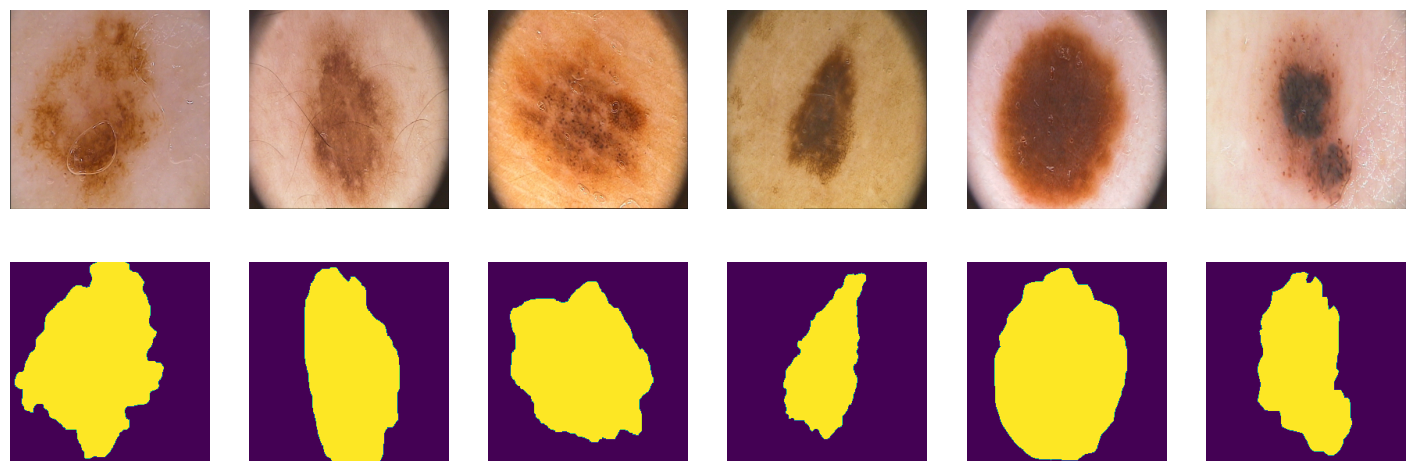

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])), batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

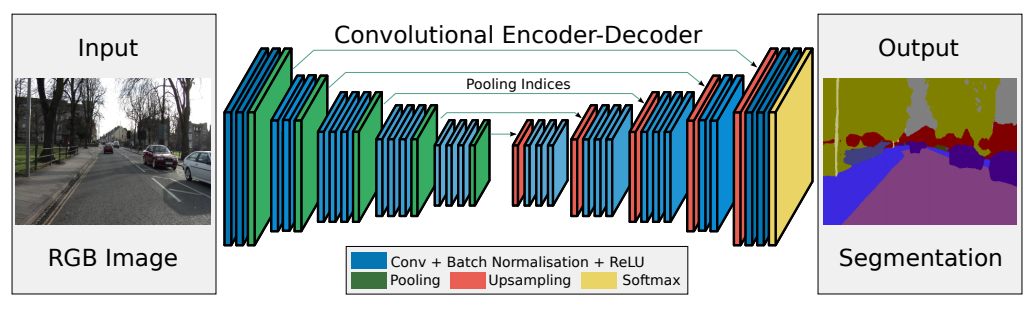

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        self.pool2 = nn.MaxPool2d(2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 32 -> 64

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 128 -> 256

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)  # number of output channels?
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # Threshold the outputs to generate binary predictions
    outputs = outputs > 0.5

    # Convert to long data type
    outputs = outputs.long()
    labels = labels.long()

    # Calculate intersection and union
    intersection = (outputs & labels).float().sum()  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum()         # Will be zero if both are 0

    # Calculate IoU
    iou = intersection / (union + 1e-6)  # Add a small epsilon to avoid division by zero

    return iou

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [16]:
def bce_loss(y_pred, y_real):
    epsilon = 1e-7  # small value to prevent log(0)
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clamp(min=epsilon, max=1-epsilon)  # clamp y_pred values
    loss = -torch.mean(y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred))  # BCE loss formula
    # loss = torch.mean(y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred)))
    return loss

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

## Train with Loss and Accuracy

In [17]:
def calculate_accuracy(Y_pred, Y_true):
    Y_pred_sigmoid = torch.sigmoid(Y_pred)  # Apply sigmoid to convert logits to probabilities
    Y_pred_binary = (Y_pred_sigmoid > 0.5).float()  # Threshold probabilities to get binary mask
    correct = (Y_pred_binary == Y_true).float()  # Compare with true labels
    accuracy = correct.sum() / correct.numel()  # Calculate accuracy
    return accuracy.item()

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    train_losses = []
    val_losses = []
    val_accuracies = []

    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_train_loss = 0

        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_train_loss += loss.item() / len(data_tr)

        train_losses.append(avg_train_loss)

        toc = time()
        print('loss: %f' % avg_train_loss)

        # show intermediate results
        model.eval()  # testing mode
        avg_val_loss = 0

        with torch.no_grad():
            Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
            Y_hat =  torch.sigmoid(Y_hat)
            Y_hat = (Y_hat > 0.5).float()

            avg_val_accuracy = 0

            for X_batch, Y_batch in data_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                Y_pred = model(X_batch)
                avg_val_loss += loss_fn(Y_pred, Y_batch).item() / len(data_val)

                # Calculate accuracy
                Y_pred_binary = (torch.sigmoid(Y_pred) > 0.5).float()  # Convert to binary
                batch_accuracy = calculate_accuracy(Y_pred_binary, Y_batch)
                avg_val_accuracy += batch_accuracy / len(data_val)

        val_losses.append(avg_val_loss)
        val_accuracies.append( avg_val_accuracy)

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))  # Adjust the figure size as per your requirement
        plt.subplots_adjust(hspace=0.5)  # Increase the value to add more space
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real', fontsize=8)
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Ground Truth', fontsize=8)
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output', fontsize=8)
            plt.axis('off')
        plt.suptitle(['%d / %d - train_loss: %f' % (epoch+1, epochs, avg_train_loss), '%d / %d - val_loss: %f' % (epoch+1, epochs, avg_val_loss)])
        plt.show()

    return train_losses, val_losses, val_accuracies

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))  # generate predictions
        scores += metric(Y_pred, Y_label.to(device)).mean().item()  # calculate metrics

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [20]:
model = SegNet().to(device)

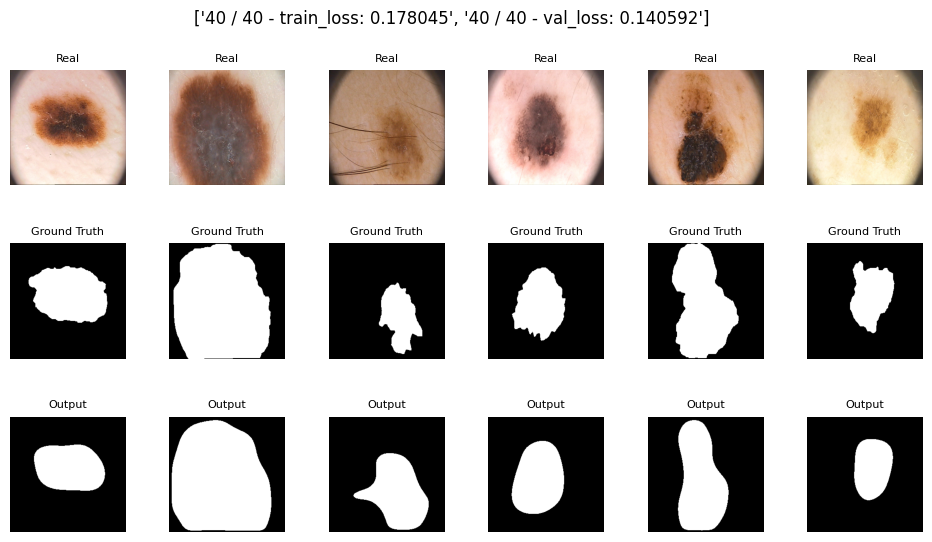

In [21]:
max_epochs = 40
optimaizer = torch.optim.Adam(model.parameters())
train_losses, val_losses, val_accuracies = train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

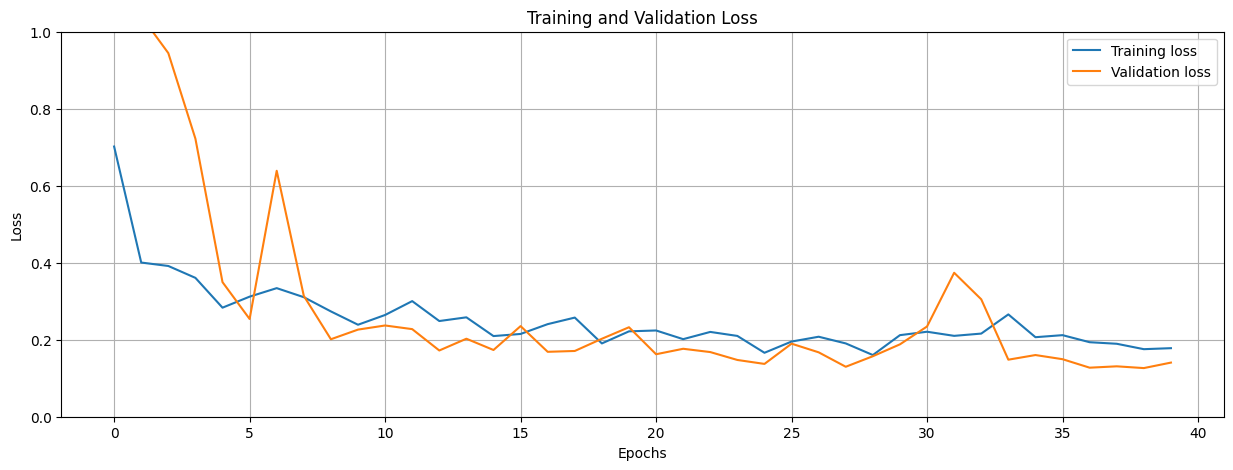

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

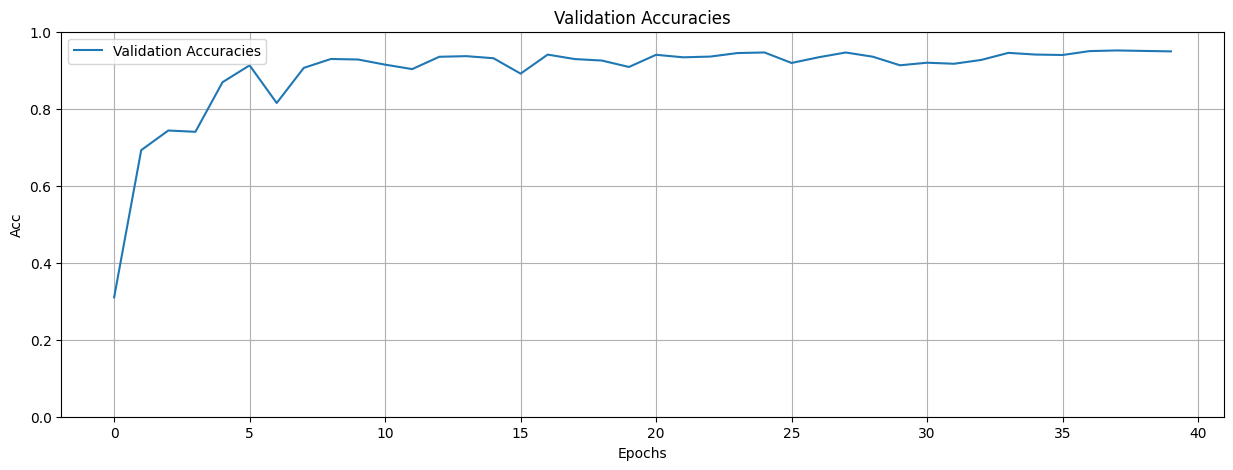

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(val_accuracies, label='Validation Accuracies')
plt.title('Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [24]:
score_model(model, iou_pytorch, data_val)

0.8307131886482239

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [25]:
def dice_loss(y_pred, y_real):
    epsilon = 1e-7
    y_pred = torch.sigmoid(y_pred)

    intersection = torch.sum(y_pred * y_real)
    union = torch.sum(y_pred) + torch.sum(y_real)

    dice = 2.0 * (intersection) / (union + epsilon)
    return 1 - dice

Проводим тестирование:

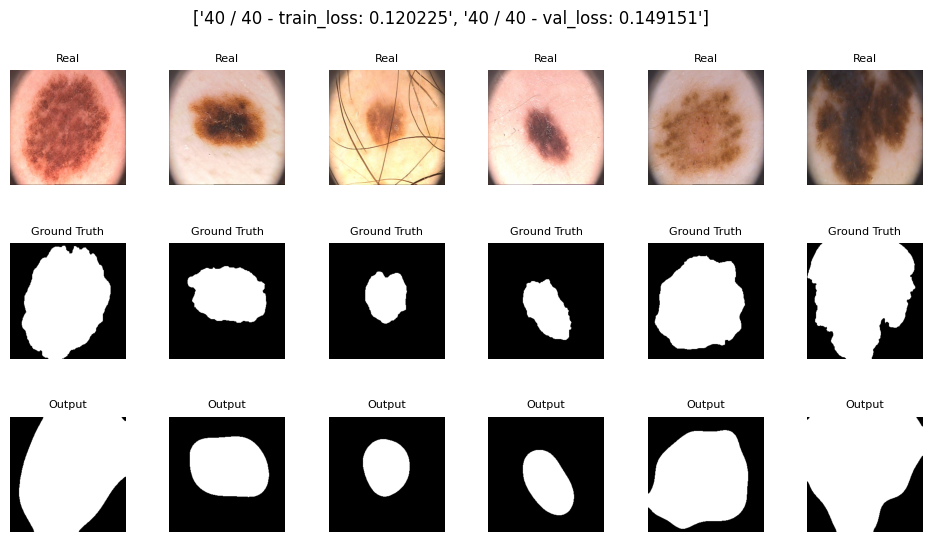

In [26]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train_losses_dice, val_losses_dice, val_acc_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

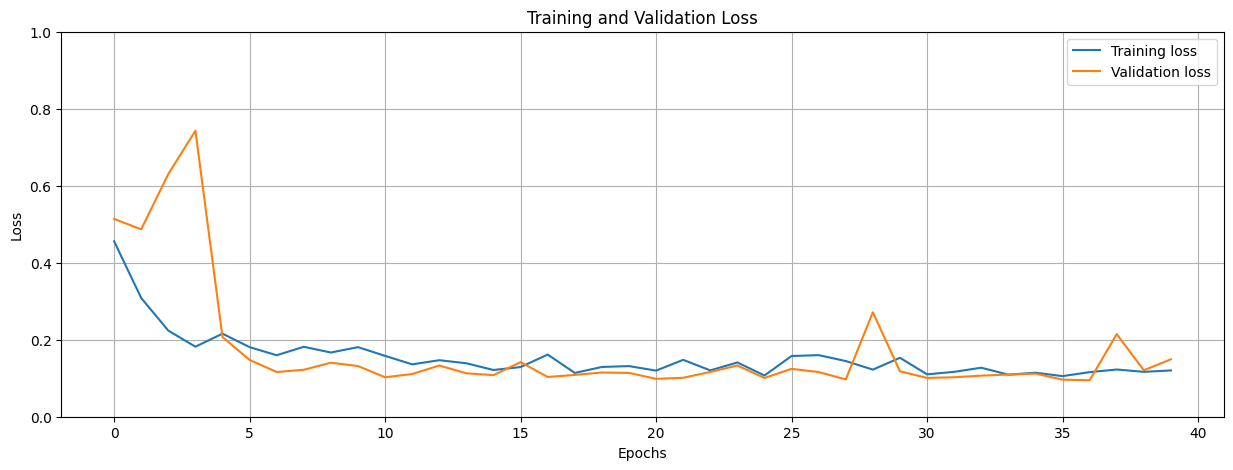

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(train_losses_dice, label='Training loss')
plt.plot(val_losses_dice, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

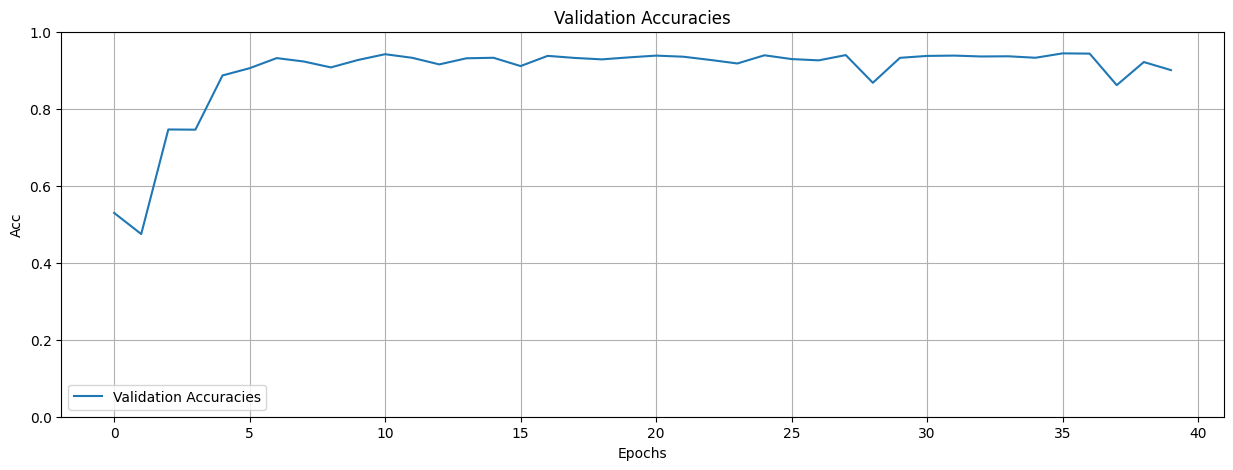

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(val_acc_dice, label='Validation Accuracies')
plt.title('Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [29]:
score_model(model_dice, iou_pytorch, data_val)

0.7527625441551209

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


## **FOCAL LOSS**
https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7

$ L = -(1-p_t)^{\gamma}\log(p_t) $$


Где $p_t=\sigma(preds) \cdot target + (1 - \sigma(preds))(1 - target)$

 $\log(p_t) = BCE$

https://pytorch.org/vision/main/_modules/torchvision/ops/focal_loss.html

In [30]:
def focal_loss(y_pred, y_real, eps = 1e-7, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clamp(min=eps, max=1-eps)  # Clamp values to avoid log(0)
    pt = y_pred * y_real + (1 - y_pred) * (1 - y_real)
    focal_loss = -(1 - pt).pow(gamma) * torch.log(pt)

    return focal_loss.mean()

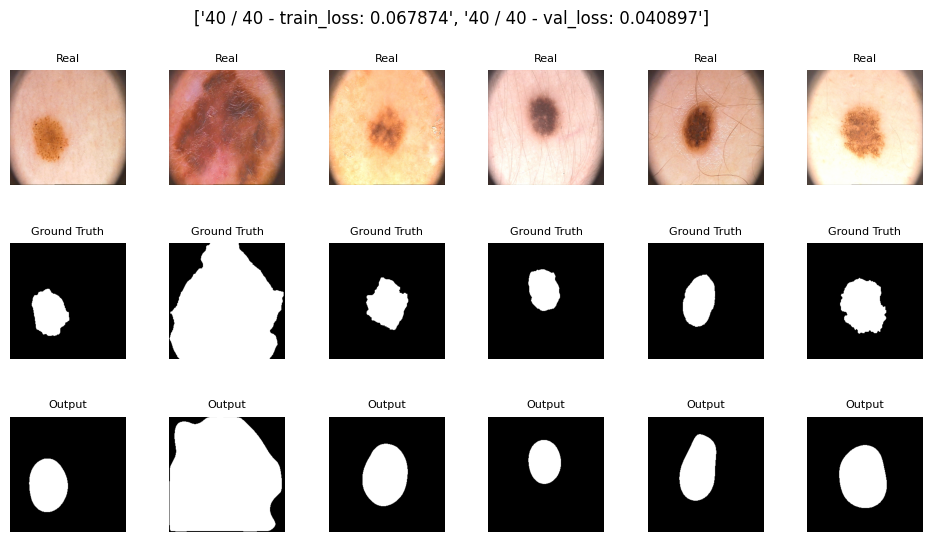

In [31]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
train_losses_focal, val_losses_focal, val_acc_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

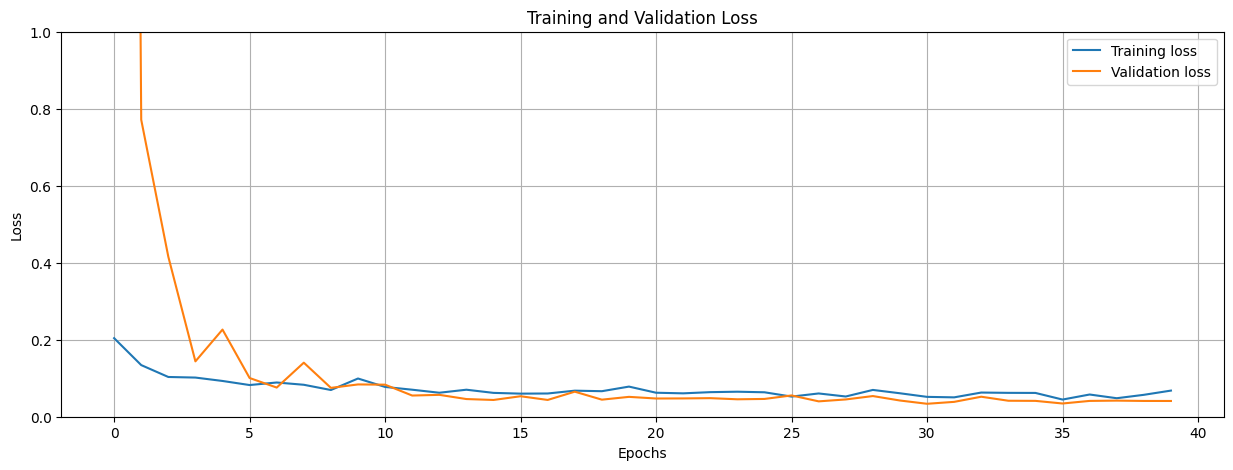

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(train_losses_focal, label='Training loss')
plt.plot(val_losses_focal, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

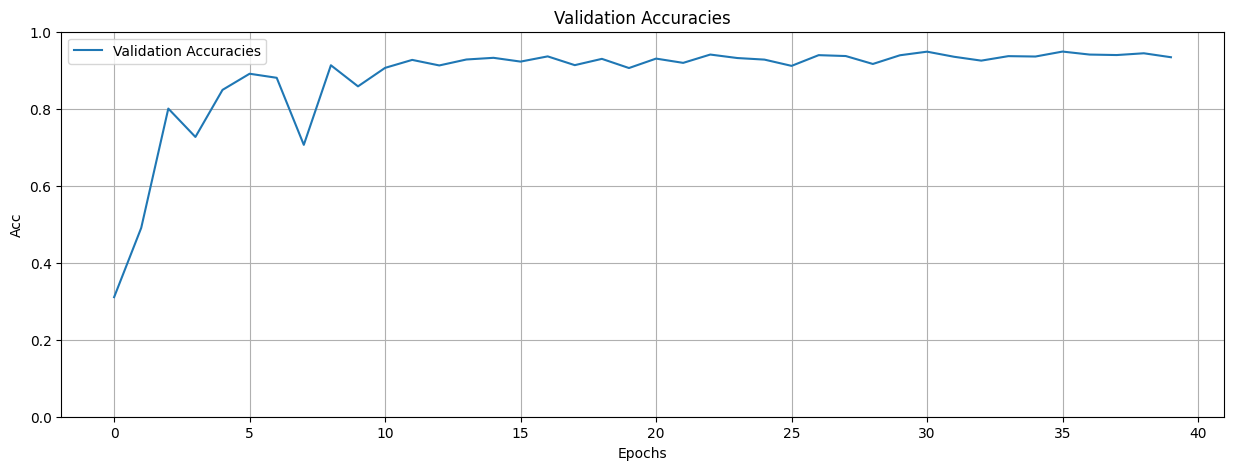

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(val_acc_focal, label='Validation Accuracies')
plt.title('Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [34]:
score_model(model_focal, iou_pytorch, data_val)

0.775917112827301

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [35]:
# <TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

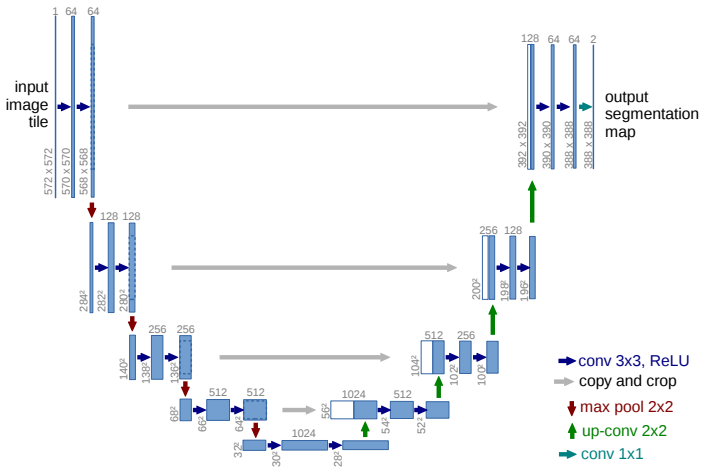

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [36]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))   # no activation
        return d3

In [37]:
unet_model = UNet().to(device)

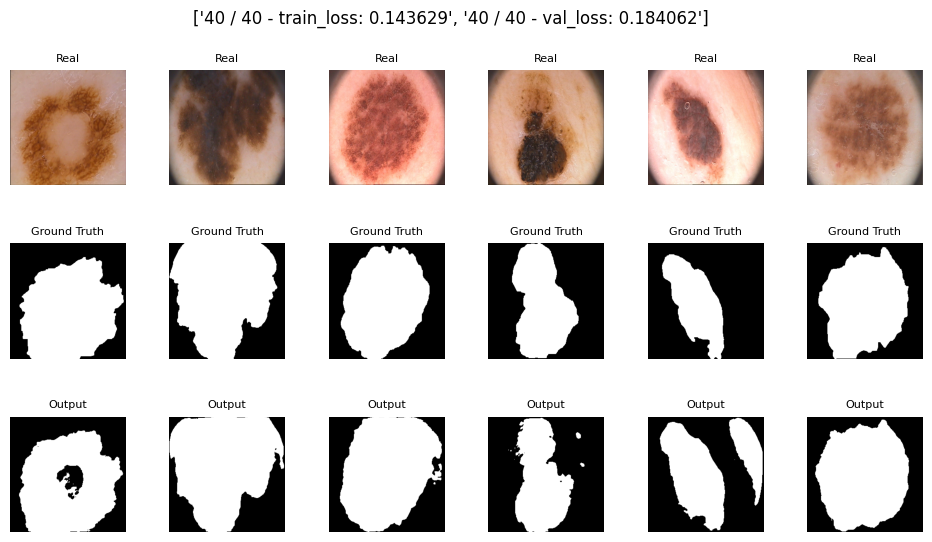

In [38]:
train_losses_unet, val_losses_unet, val_acc_unet_bce = train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 40, data_tr, data_val)

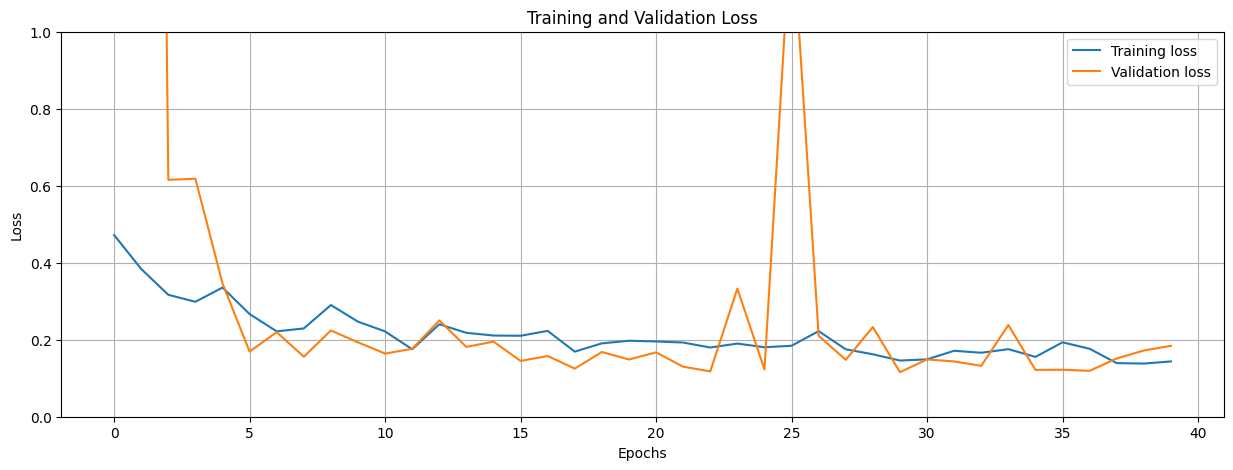

In [39]:
plt.figure(figsize=(15, 5))
plt.plot(train_losses_unet, label='Training loss')
plt.plot(val_losses_unet, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

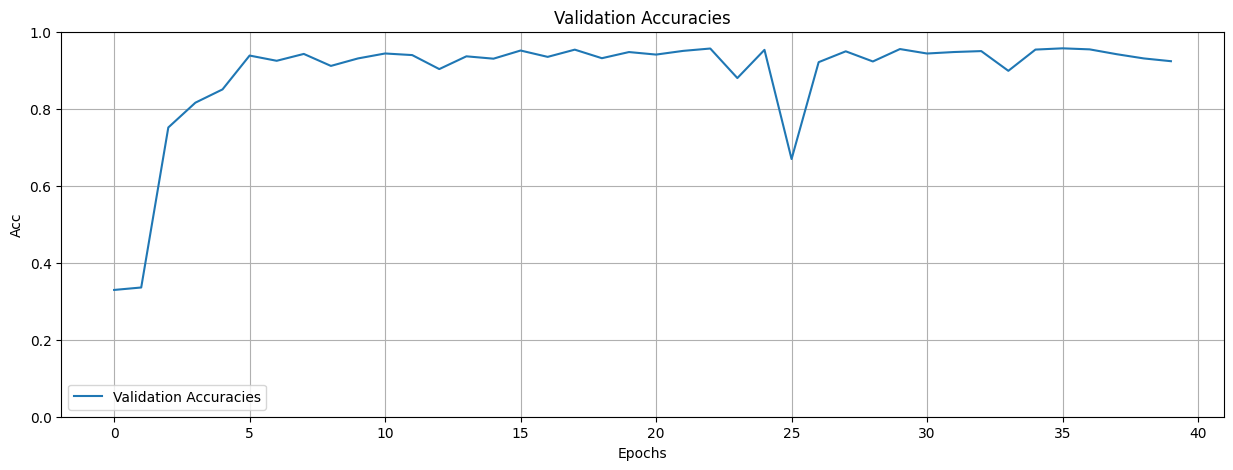

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(val_acc_unet_bce, label='Validation Accuracies')
plt.title('Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [41]:
score_model(unet_model, iou_pytorch, data_val)

0.8365788698196411

In [42]:
unet_model_dice = UNet().to(device)

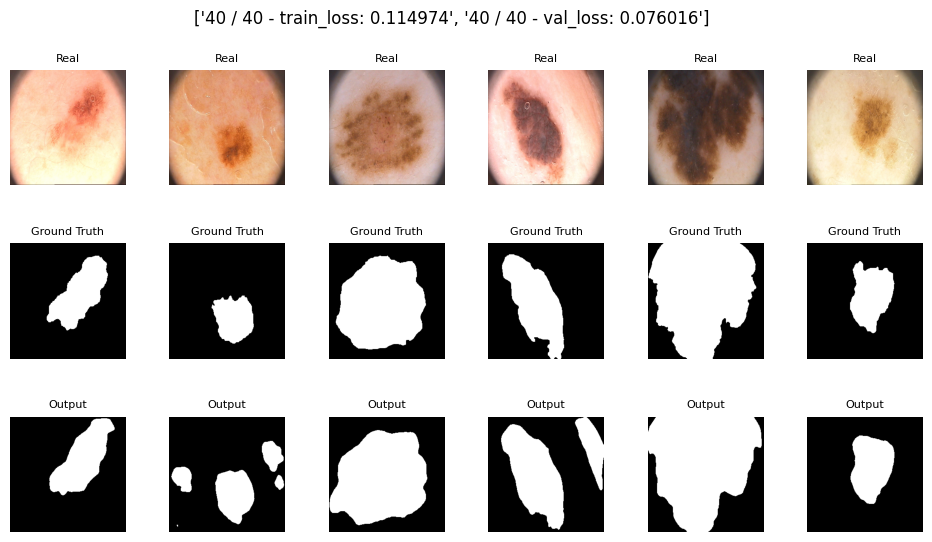

In [43]:
train_losses_unet_dice, val_losses_unet_dice, val_acc_unet_dice = train(unet_model_dice, optim.Adam(unet_model_dice.parameters()), dice_loss, 40, data_tr, data_val)

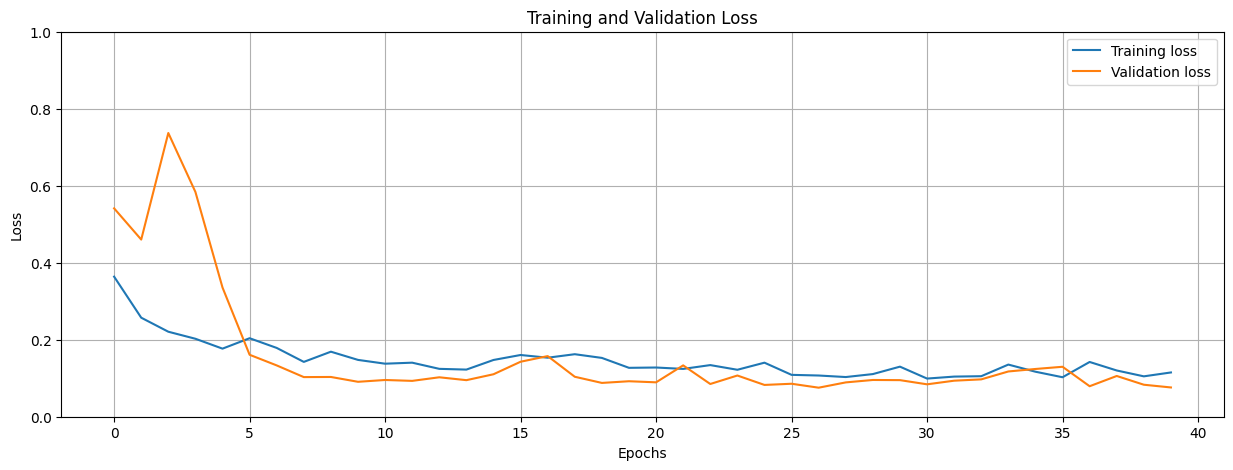

In [44]:
plt.figure(figsize=(15, 5))
plt.plot(train_losses_unet_dice, label='Training loss')
plt.plot(val_losses_unet_dice, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

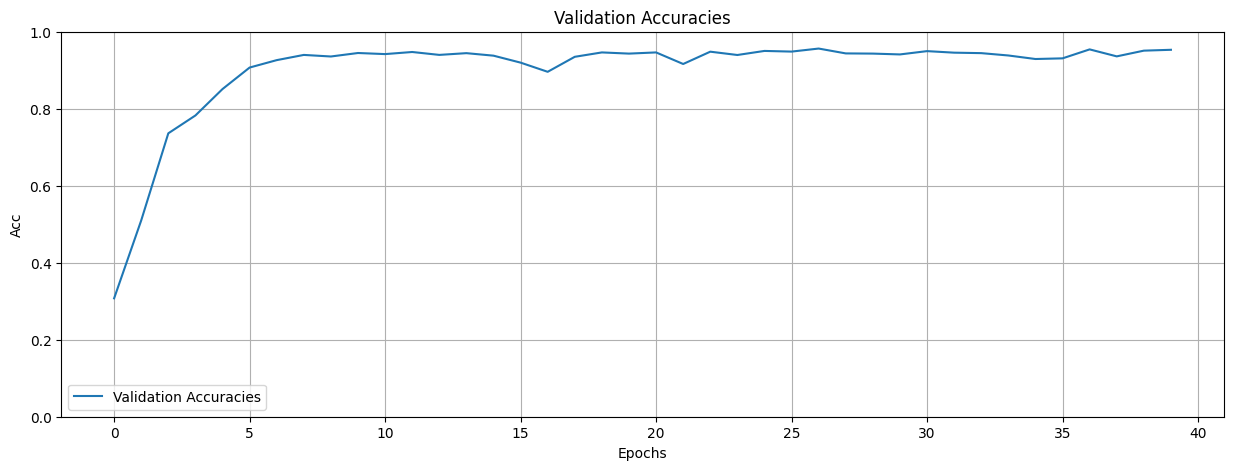

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(val_acc_unet_dice, label='Validation Accuracies')
plt.title('Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [46]:
score_model(unet_model_dice, iou_pytorch, data_val)

0.8597926735877991

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [47]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        # Replace max-pooling with stride-2 convolution
        self.con_str_0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        # Replace max-pooling with stride-2 convolution
        self.con_str_1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        # Replace max-pooling with stride-2 convolution
        self.con_str_2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        # Replace max-pooling with stride-2 convolution
        self.con_str_3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        )

        # decoder (upsampling)

        # Replace upsampler with transpose convolution
        self.transpose0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512 + 512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        # Replace upsampler with transpose convolution
        self.transpose1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        # Replace upsampler with transpose convolution
        self.transpose2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        # Replace upsampler with transpose convolution
        self.transpose3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.con_str_0(e0))
        e2 = self.enc_conv2(self.con_str_1(e1))
        e3 = self.enc_conv3(self.con_str_2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.con_str_3(e3))

        # decoder
        d0 = self.dec_conv0(torch.cat((self.transpose0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.transpose1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.transpose2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.transpose3(d2), e0), dim=1))   # no activation
        return d3

In [48]:
unet2_model = UNet2().to(device)

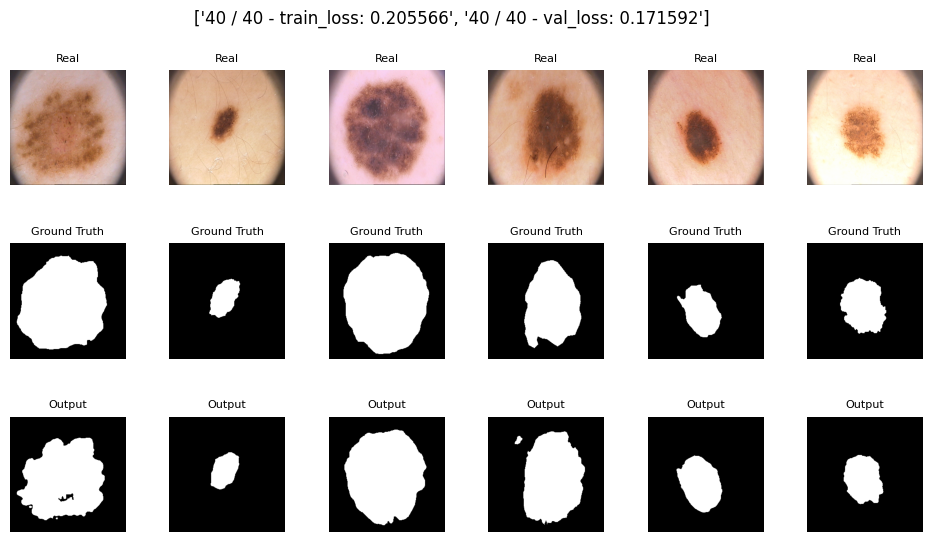

In [49]:
train_losses_unet2, val_losses_unet2, val_acc_unet2_bce = train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 40, data_tr, data_val)

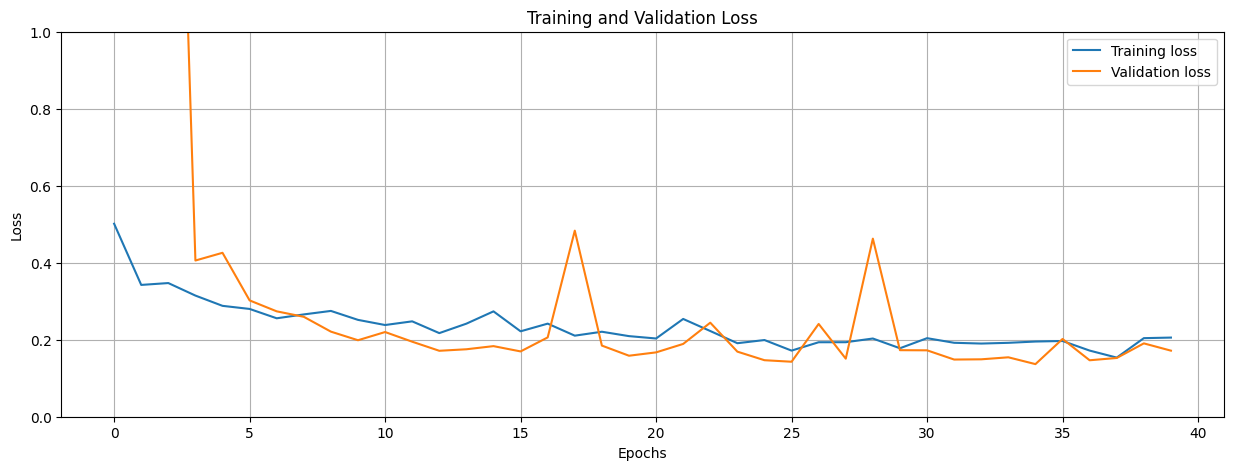

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(train_losses_unet2, label='Training loss')
plt.plot(val_losses_unet2, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

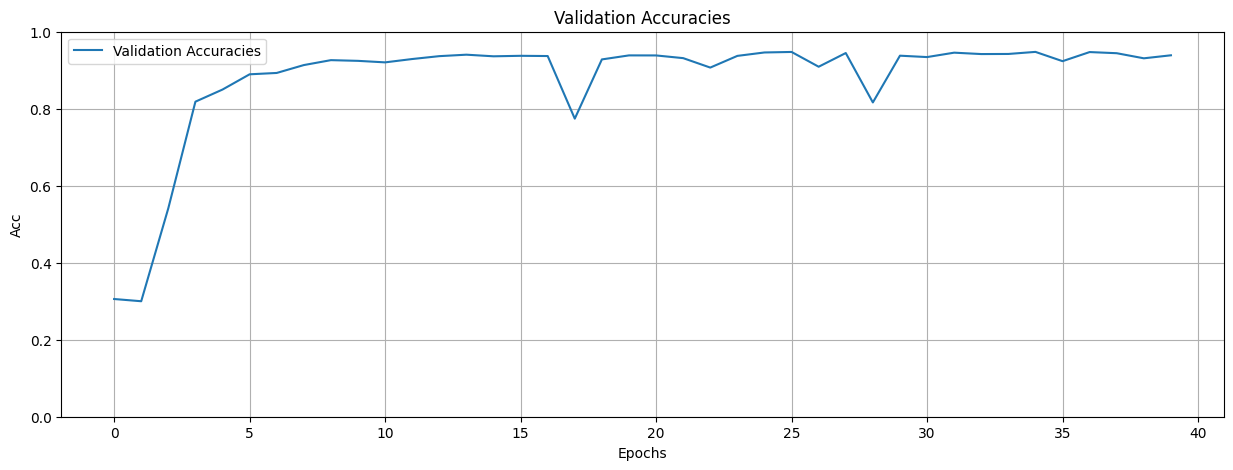

In [51]:
plt.figure(figsize=(15, 5))
plt.plot(val_acc_unet2_bce, label='Validation Accuracies')
plt.title('Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [52]:
score_model(unet2_model, iou_pytorch, data_val)

0.7927666068077087

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# Вывод

## Validation Loss

Ниже построены графики Accuracy на валидационных данных. Так же приведен счет моделей в таблице, по которому я выбираю три лучших модели и провожу предсказание на тесте.

## Validation Loss

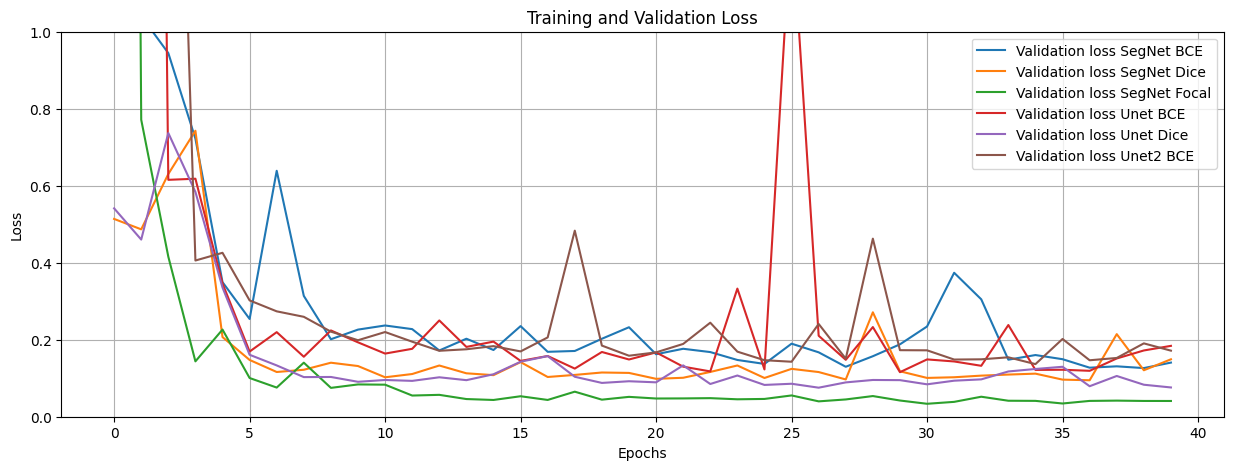

In [61]:
plt.figure(figsize=(15, 5))
plt.plot(val_losses, label='Validation loss SegNet BCE')
plt.plot(val_losses_dice, label='Validation loss SegNet Dice')
plt.plot(val_losses_focal, label='Validation loss SegNet Focal')
plt.plot(val_losses_unet, label='Validation loss Unet BCE')
plt.plot(val_losses_unet_dice, label='Validation loss Unet Dice')
plt.plot(val_losses_unet2, label='Validation loss Unet2 BCE')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

## Validation Accuracy

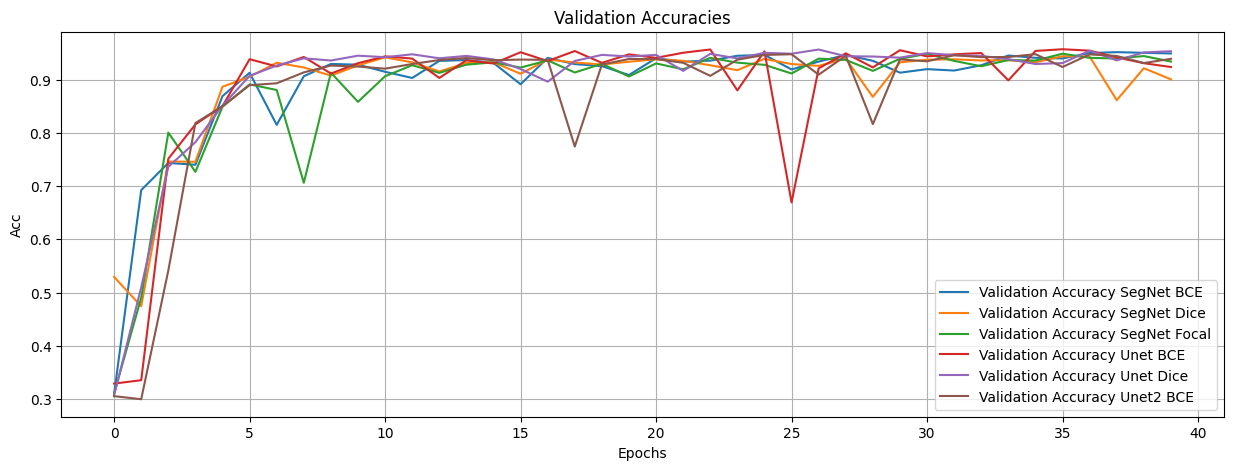

In [53]:
plt.figure(figsize=(15, 5))
plt.plot(val_accuracies, label='Validation Accuracy SegNet BCE')
plt.plot(val_acc_dice, label='Validation Accuracy SegNet Dice')
plt.plot(val_acc_focal, label='Validation Accuracy SegNet Focal')
plt.plot(val_acc_unet_bce, label='Validation Accuracy Unet BCE')
plt.plot(val_acc_unet_dice, label='Validation Accuracy Unet Dice')
plt.plot(val_acc_unet2_bce, label='Validation Accuracy Unet2 BCE')
plt.title('Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
import pandas as pd

SegNet_BCE = score_model(model, iou_pytorch, data_val)
SegNet_Dice = score_model(model_dice, iou_pytorch, data_val)
SegNet_Focal = score_model(model_focal, iou_pytorch, data_val)
Unet_BCE = score_model(unet_model, iou_pytorch, data_val)
Unet_Dice = score_model(unet_model_dice, iou_pytorch, data_val)
Unet2_BCE = score_model(unet2_model, iou_pytorch, data_val)

scores = pd.DataFrame([SegNet_BCE, SegNet_Dice, SegNet_Focal, Unet_BCE, Unet_Dice, Unet2_BCE]).T
scores.columns = ['SegNet_BCE', 'SegNet_Dice', 'SegNet_Focal', 'Unet_BCE', 'Unet_Dice', 'Unet2_BCE']

In [55]:
scores

,SegNet_BCE,SegNet_Dice,SegNet_Focal,Unet_BCE,Unet_Dice,Unet2_BCE
0,0.8409,0.744415,0.772788,0.838444,0.861324,0.786903


## Test dataset

Беру три модели для предсказания и оценки модели на тестовой выборке.

In [59]:
test_segnet_bce = score_model(model, iou_pytorch, data_ts)
# test_segnet_dice = score_model(model_dice, iou_pytorch, data_ts)
test_unet_bce = score_model(unet_model, iou_pytorch, data_ts)
test_unet_dice = score_model(unet_model_dice, iou_pytorch, data_ts)

print(f'model score for SegNetModel with Dice loss function is {test_segnet_bce}')
# print(f'model score for SegNetModel with Dice loss function is {test_segnet_dice}')
print(f'model score for Une with BCE loss function is {test_unet_bce}')
print(f'model score for Unet with Dice loss function is {test_unet_dice}')

model score for SegNetModel with Dice loss function is 0.7750273942947388
model score for Une with BCE loss function is 0.8020395636558533
model score for Unet with Dice loss function is 0.8413131475448609


Наилучший счет показала модель Unet with DICE, счет модели на тесте составил 0,84